# Detecting Trivial outliers
> [github.com/alik604](https://github.com/alik604)

My version of [krishnaik06's tutorial](https://github.com/krishnaik06/Finding-an-Outlier/blob/master/Finding%20an%20outlier%20in%20a%20Dataset.ipynb) 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
data = np.random.normal(0,1, size = 1000000) # 1,000,000

or apply `sklearn.preprocessing.standardscaler`, though that might not be valid method, as you may* see outliers where they are non.

suppose all-1 students [95%..100%], and one gets 101%. Calling that a outlier might be a False Positive, possibly due to lack of variance in the data.. other problems may occur if they is a skew  

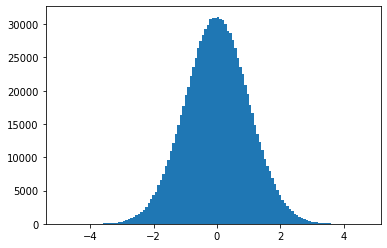

In [3]:
_ = plt.hist(data, bins = 123) # bins sets the granularity

## Z Score
Z-score is measured in terms of standard deviations from the mean

In [4]:
def detect_outliers(data, threshold = 4):
    outliers=[]
    mean, std = np.mean(data), np.std(data)
    
    for i in data:
        z_score = (i - mean)/std 
        if np.abs(z_score) > threshold:
            outliers.append(i)
            
    return outliers

outliers = detect_outliers(data)

0.004 %


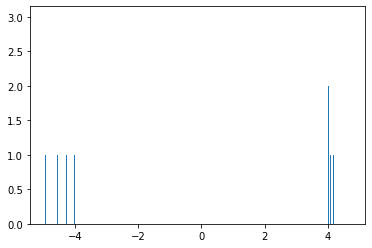

In [5]:
print(len(outliers)/len(data) * 100, '%')
_ = plt.hist(outliers, bins = 1234) # Don't be mislead by the hight

# 68 95 and 99.7 rule

## Interquartile range
[wiki](https://en.wikipedia.org/wiki/Interquartile_range#Outliers)

In [6]:
q1, q2, q3 = np.quantile(data, [0.25, 0.5, 0.75])
print(q1, q2, q3)

-0.6737690134604004 0.00014157568548034866 0.6753079047190734


In [7]:
IQR = q3 - q1 
lower_bound = q1 - 1.5 * IQR
upper_bound = q3 + 1.5 * IQR
print(lower_bound, upper_bound)

-2.6973843907296113 2.6989232819882845


In [8]:
def detect_outliers_IQR(data, lower_bound, upper_bound, multiplier = 1.5):
    '''Outliers are defined as mild above Q3 + 1.5 IQR and extreme above Q3 + 3 IQR. Potential `multiplers` = {1.5, 3...}'''
    q1, q2, q3 = np.quantile(data, [0.25, 0.5, 0.75])
    IQR = q3 - q1 
    lower_bound, upper_bound = q1 - multiplier * IQR, q3 + multiplier * IQR
    return[data_point for data_point in data if data_point < lower_bound or data_point > upper_bound]

outliers = detect_outliers_IQR(data, lower_bound, upper_bound, multiplier = 2.25)

Contaminated 0.0183%


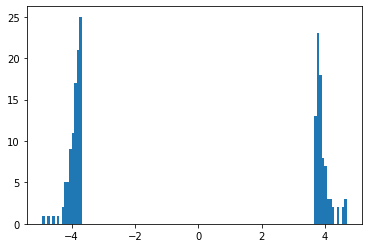

In [9]:
_ = plt.hist(outliers, bins = 123) # Don't be mislead by the hight
print('Contaminated {:.4}%'.format(len(outliers)/len(data) * 100))

## PCA based

Principal component analysis (PCA) can be used in detecting outliers. PCA is a **linear** dimensionality reduction ~using Singular Value Decomposition~ of the data to project it to a lower dimensional space.

In this procedure, covariance matrix of the data can be decomposed to orthogonal vectors, called eigenvectors, associated with eigenvalues. The eigenvectors with **high eigenvalues** capture most of the variance in the data.

Therefore, a low dimensional hyperplane constructed by **k eigenvectors** can capture most of the variance in the data. However, outliers are different from normal data points, which is more obvious on the hyperplane constructed by the eigenvectors with **small eigenvalues**.

-from [PYOD.medels.pca](https://pyod.readthedocs.io/en/latest/_modules/pyod/models/pca.html)


[Here](https://medium.com/@aptrishu/understanding-principle-component-analysis-e32be0253ef0) is a popular medium article to further confuse yourself :)



From [python-engineer's MLfromscratch](https://github.com/python-engineer/MLfromscratch/blob/master/mlfromscratch/pca.py)
``` Python 
import numpy as np

class PCA:

    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.mean = None

    def fit(self, X):
        # Mean centering
        self.mean = np.mean(X, axis=0) ## column wise mean (maybe...) 
        X = X - self.mean
        # covariance, function needs samples as columns
        cov = np.cov(X.T)
        # eigenvalues, eigenvectors
        eigenvalues, eigenvectors = np.linalg.eig(cov)
        # -> eigenvector v = [:,i] column vector, transpose for easier calculations
        # sort eigenvectors
        eigenvectors = eigenvectors.T
        idxs = np.argsort(eigenvalues)[::-1] ## [::-1] is a reverse, so its from LARGEST to smallest
        eigenvalues = eigenvalues[idxs]
        eigenvectors = eigenvectors[idxs]
        # store first n eigenvectors
        self.components = eigenvectors[0:self.n_components]

    def transform(self, X):
        # project data
        X = X - self.mean
        return np.dot(X, self.components.T)
    
```

so, with[this](https://h1ros.github.io/posts/anomaly-detection-by-pca-in-pyod/) we can...

In [10]:
import seaborn as sns
%matplotlib inline

# PyOD
from pyod.utils.data import generate_data
from pyod.models.pca import PCA
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize

In [11]:
X_train, y_train = generate_data(behaviour='new', n_features=5, train_only=True, contamination= 0.01)
df_train = pd.DataFrame(X_train)
df_train['y'] = y_train

df_train[df_train['y'] == 1].head(5)

,0,1,2,3,4,y
990,0.335051,0.317715,-0.547847,-0.224460,-0.710366,1.0
991,0.295700,0.514230,-0.688627,-0.258799,0.190948,1.0
992,0.747994,-0.132740,-0.294112,-0.199834,0.353021,1.0
993,-0.595980,0.925083,-0.264035,0.580320,-0.530802,1.0
994,-0.179610,0.391198,0.048759,0.062924,-0.356275,1.0


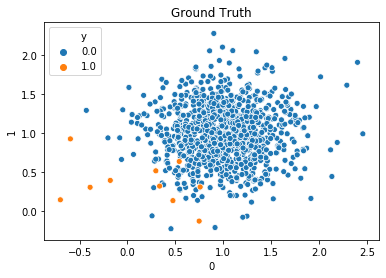

In [12]:
sns.scatterplot(x=0, y=1, hue='y', data=df_train);
plt.title('Ground Truth');

In [13]:
clf = PCA(contamination = 0.1) # default parameters 
_ = clf.fit(X_train) 

Portion of contaminated data: 0.1


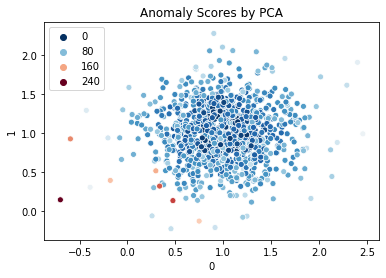

In [14]:
y_train_pred = clf.labels_
y_train_scores = clf.decision_scores_
print('Portion of contaminated data:',np.sum(clf.labels_)/df_train.shape[0])
plt.title('Anomaly Scores by PCA');
sns.scatterplot(x=0, y=1, hue=y_train_scores, data=df_train, palette='RdBu_r');

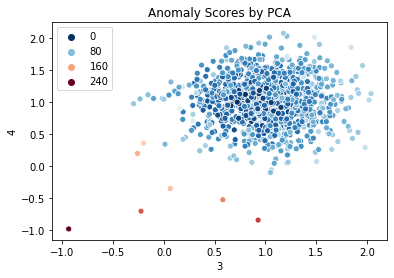

In [15]:
plt.title('Anomaly Scores by PCA');
sns.scatterplot(x=3, y=4, hue=y_train_scores, data=df_train, palette='RdBu_r');

In [16]:
clf = PCA(contamination = 0.1).fit(X_train) # default parameters 
accuracy = np.sum(y_train == clf.labels_) / y_train.shape[0] # Correctly classified over all 
print('Accuracy {:2}%'.format(accuracy * 100))


clf = PCA(contamination = 0.01).fit(X_train) 
accuracy = np.sum(y_train == clf.labels_) / y_train.shape[0] # Correctly classified over all 
print('Accuracy {:2}%'.format(accuracy * 100))

Accuracy 90.8%
Accuracy 99.6%


In [24]:
# evaluate_print('PCA', y_train, clf.labels_)
# PCA ROC:0.9545, precision @ rank n:0.0

PCA ROC:0.899, precision @ rank n:0.8


## Applying Z-Score

In [19]:
print(f'Rows:   {X_train.shape[0]}, Columns: {X_train.shape[1]}') # 1000 rows, 5 columns)


# Take the Mean and STD of each feasture
mean = np.mean(X_train, axis = 0)
print('mean: ', mean)

std = np.std(X_train, axis = 0)
print('STD:  ', std)

Rows:   1000, Columns: 5
mean:  [0.99331223 0.99953081 0.99452236 0.99456062 0.99775592]
STD:   [0.38831663 0.37069183 0.37346391 0.37460262 0.38150632]


In [20]:
def optimize(STD_multiplier = 3.5):
    pred = np.zeros(y_train.shape)
    for idx_row, row in enumerate(X_train): # idx_row goes [0..1000)
        for idx, data_point in enumerate(row):
            SD = STD_multiplier * std[idx]
            if((data_point < mean[idx] - SD) or (data_point > mean[idx] + SD)):
                pred[idx_row] = 1 
    accuracy = np.sum(y_train == pred) / y_train.shape[0] # Correctly classified over all 
    print(f'Acc: {accuracy*100:.4}% with scaler = {STD_multiplier}')

In [21]:
ls = [0.5 * i for i in range(15)]
for i in ls:
    optimize(i)

Acc: 1.0% with scaler = 0.0
Acc: 2.2% with scaler = 0.5
Acc: 16.9% with scaler = 1.0
Acc: 53.8% with scaler = 1.5
Acc: 82.1% with scaler = 2.0
Acc: 94.3% with scaler = 2.5
Acc: 98.6% with scaler = 3.0
Acc: 99.4% with scaler = 3.5
Acc: 99.5% with scaler = 4.0
Acc: 99.3% with scaler = 4.5
Acc: 99.1% with scaler = 5.0
Acc: 99.0% with scaler = 5.5
Acc: 99.0% with scaler = 6.0
Acc: 99.0% with scaler = 6.5
Acc: 99.0% with scaler = 7.0
